In [1]:
import math
import decimal
import numpy as np
import librosa
import librosa.display
from scipy.fftpack import dct

import matplotlib.pyplot as plt
from IPython.display import Audio


%matplotlib inline

In [2]:
!ls RAVDESS/0_all_speech

angry-normal-female-1033.wav	fearful-strong-male-1012.wav
angry-normal-female-1035.wav	fearful-strong-male-1086.wav
angry-normal-female-1052.wav	fearful-strong-male-1118.wav
angry-normal-female-1065.wav	fearful-strong-male-1119.wav
angry-normal-female-110.wav	fearful-strong-male-1129.wav
angry-normal-female-1150.wav	fearful-strong-male-1224.wav
angry-normal-female-1152.wav	fearful-strong-male-1240.wav
angry-normal-female-1156.wav	fearful-strong-male-1246.wav
angry-normal-female-1181.wav	fearful-strong-male-1253.wav
angry-normal-female-126.wav	fearful-strong-male-1273.wav
angry-normal-female-137.wav	fearful-strong-male-1298.wav
angry-normal-female-1398.wav	fearful-strong-male-1301.wav
angry-normal-female-1408.wav	fearful-strong-male-1310.wav
angry-normal-female-1417.wav	fearful-strong-male-1336.wav
angry-normal-female-1429.wav	fearful-strong-male-1366.wav
angry-normal-female-142.wav	fearful-strong-male-1374.wav
angry-normal-female-156.wav	fearful-strong-male-1379.wav
angry-normal-female

In [3]:
path = 'RAVDESS/0_all_speech'
# file = '/angry-strong-01-01-male.wav'
# file = '/calm-normal-01-01-male.wav'
# file='/disgust-strong-01-02-male.wav'
# file = '/surprised-strong-02-01-male.wav'
file = '/fearful-strong-male-215.wav'

In [4]:
signal, sampling_rate = librosa.core.load(path+file, sr=48000)

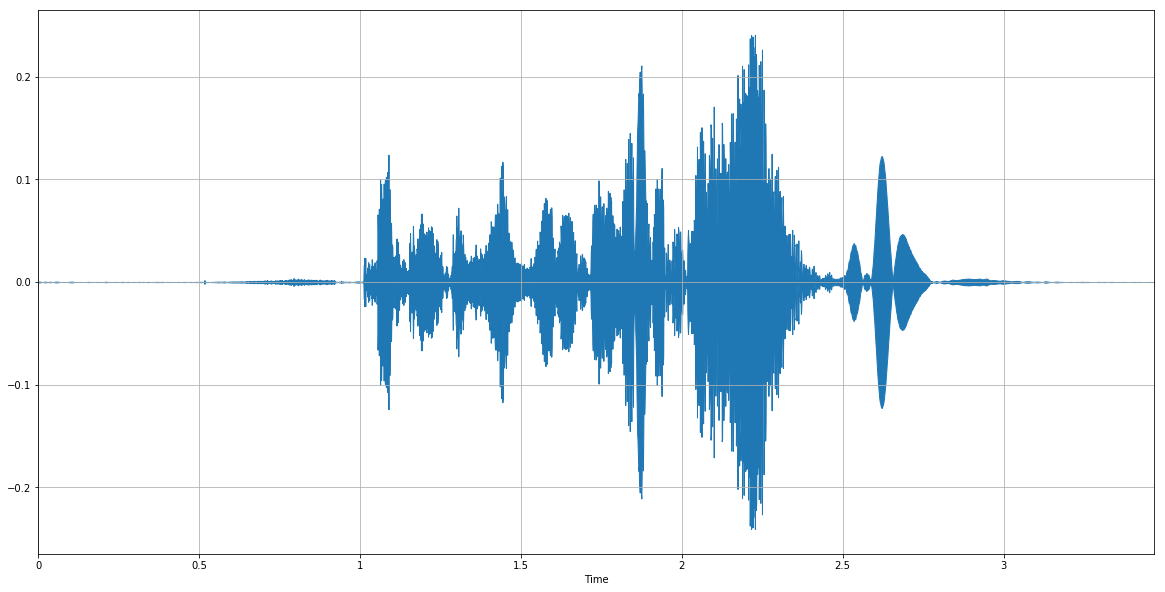

In [6]:
plt.figure(figsize=(20, 10))
plt.grid()
librosa.display.waveplot(signal, sr=sampling_rate)

In [7]:
# defining main parameters to compute mfcc

window_length = 0.025 # the length of the analysis window in seconds (25 milliseconds)
window_step = 0.01    # the step between successive windows in seconds (10 milliseconds)
pre_emphasis = 0.97   # coefficient

nfilt = 26 # ?? the number of filters in the filterbank, default 26.
nfft = 512 # ?? the FFT size. Default is 512.

numcep = 13 # ?? num of cepstral coefs
ceplifter = 0 # apply a lifter to final cepstral coefficients. 0 is no lifter 22

winfunc = lambda x: np.ones((x,)) # np.hamming # window function

# helper functions
def round_half_up(number):
    return int(decimal.Decimal(number).quantize(decimal.Decimal('1'), rounding=decimal.ROUND_HALF_UP))

def hz2mel(hz):
    return 2595 * np.log10(1+hz/700.)

def mel2hz(mel):
    return 700*(10**(mel/2595.0)-1)
def lifter(cepstra, L=22):
    if L > 0:
        nframes,ncoeff = np.shape(cepstra)
        n = np.arange(ncoeff)
        lift = 1 + (L/2.)*np.sin(np.pi*n/L)
        return lift*cepstra
    else:
        return cepstra

In [8]:
highfreq = sampling_rate/2  # highfreq or sampling_rate/2
lowfreq = 0

In [9]:
# Step 1: Pre-emphasis

emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

In [10]:
# Step 2: Framing


# frames = sigproc.framesig(signal, winlen*samplerate, winstep*samplerate, winfunc)

signal_length = len(emphasized_signal)

# Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round_half_up(window_length * sampling_rate))
frame_step = int(round_half_up(window_step * sampling_rate))

# Make sure that we have at least 1 frame
if signal_length <= frame_length:
    numframes = 1
else:
    numframes = 1 + int(math.ceil((1.0 * signal_length - frame_length) / frame_step))
    
pad_signal_length = int((numframes - 1) * frame_step + frame_length)

zeros = np.zeros((pad_signal_length - signal_length,))
padsignal = np.concatenate((signal, zeros))    


# think about it: stride trick

indices = np.tile(np.arange(0, frame_length), (numframes, 1)) + np.tile(\
                                            np.arange(0, numframes * frame_step, frame_step), (frame_length, 1)).T

indices = np.array(indices, dtype=np.int32)
frames = padsignal[indices]
win = np.tile(winfunc(frame_length), (numframes, 1))

framed_signal = frames * win

In [12]:
framed_signal.shape

(346, 1200)

In [ ]:
# window

In [14]:
# Step 3: Power Spectrum

# 1) magnitude spectrum of each frame in frames

complex_spectrum = np.fft.rfft(framed_signal, nfft) #  one-dimensional discrete Fourier Transform for real input
magnitude_spectrum_of_signal =  np.absolute(complex_spectrum)

power_spectrum = 1.0 / nfft * np.square(magnitude_spectrum_of_signal)
power_spectrum = np.where(power_spectrum==0,np.finfo(float).eps,power_spectrum) # заменить нули на машинный епсилон

energy = np.sum(power_spectrum,1) # this stores the total energy in each frame
energy = np.where(energy == 0, np.finfo(float).eps, energy) # if energy is zero, we get problems with log

In [15]:
# Step 4: Filter banks

# fb = get_filterbanks(nfilt,nfft,samplerate,lowfreq,highfreq)

# compute points evenly spaced in mels
lowmel = hz2mel(lowfreq)
highmel = hz2mel(highfreq)
melpoints = np.linspace(lowmel,highmel,nfilt+2)

# our points are in Hz, but we use fft bins, so we have to convert
#  from Hz to fft bin number
bin = np.floor((nfft+1)*mel2hz(melpoints)/sampling_rate)

fbank = np.zeros([nfilt, nfft//2 + 1])

for j in range(0,nfilt):
    for i in range(int(bin[j]), int(bin[j+1])):
        fbank[j,i] = (i - bin[j]) / (bin[j+1]-bin[j])
    for i in range(int(bin[j+1]), int(bin[j+2])):
        fbank[j,i] = (bin[j+2]-i) / (bin[j+2]-bin[j+1])

In [16]:
# Step 5: MFCCs
features = np.dot(power_spectrum, fbank.T) # compute the filterbank energies
features = np.where(features == 0,np.finfo(float).eps, features) 

In [17]:
features = np.log(features)

# apply discrete cosine transform
features = dct(features, type=2, axis=1, norm='ortho')[:,:numcep]

# Apply a cepstral lifter the the matrix of cepstra. 
# This has the effect of increasing the magnitude of the high frequency DCT coeffs.

mfcc = lifter(features, ceplifter)

# if appendEnergy: feat[:,0] = numpy.log(energy) # replace first cepstral coefficient with log of frame energy

In [18]:
Audio(path + file)

In [39]:
libmfcc = librosa.feature.mfcc(y=signal, sr=sampling_rate, n_mfcc=45)

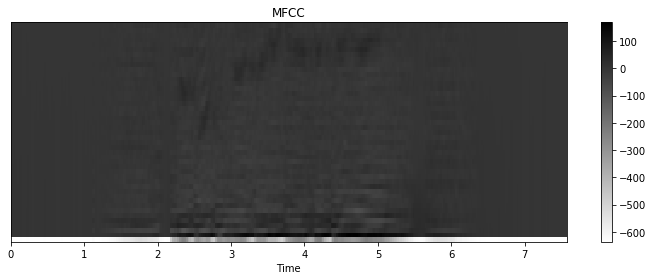

In [40]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(libmfcc, x_axis='time', cmap='binary')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

In [43]:
libmfcc.shape

(45, 326)

In [38]:
# libmfcc[2].shape

In [34]:
libmfcc[0]

array([-632.71697925, -632.59314896, -632.28197855, -632.43129405,
       -632.75253214, -632.6001862 , -632.36084936, -634.23533659,
       -634.59052163, -632.91204188, -632.20328258, -633.84976524,
       -635.0784078 , -635.58329636, -634.45560553, -633.87369089,
       -634.58017296, -633.91028067, -634.49605254, -633.15062226,
       -632.54818752, -633.80138407, -634.48619321, -634.99399963,
       -634.03325374, -634.18863865, -635.11505542, -635.4831077 ,
       -635.4937615 , -634.20786664, -633.41552891, -633.68285797,
       -633.4957501 , -634.13593215, -633.79714694, -634.02252612,
       -634.4029417 , -635.46242066, -634.38990388, -634.5740127 ,
       -635.74509372, -635.80670537, -634.73767114, -634.28039193,
       -634.91355536, -634.43039108, -634.98300864, -634.7459949 ,
       -625.7745838 , -628.09813151, -634.9159997 , -635.0358244 ,
       -631.8777151 , -629.52657132, -626.76678164, -626.05540928,
       -624.74855287, -621.29837375, -616.95392134, -611.74956

In [42]:
libmfcc.T.shape

(326, 45)

In [41]:
 np.mean(libmfcc.T,axis=0)

array([-4.90347896e+02,  5.69943798e+01, -8.28151496e+00,  1.37612197e+01,
        5.47207560e+00,  1.38470526e+01, -5.44968571e+00,  1.01581747e+00,
       -1.16180650e+00, -7.75760772e-01, -3.36572468e+00,  2.22309826e+00,
       -6.95044246e-01, -1.03650484e+00,  7.86085362e-01,  4.05429680e-01,
       -2.09882393e+00,  1.36610505e+00,  1.05205894e+00, -4.86169227e-01,
        9.33591668e-01, -6.27768174e-01,  2.27818089e-01,  2.07533467e+00,
       -1.06343215e+00,  1.24129742e+00,  1.35555480e+00,  7.79602294e-01,
       -5.41934513e-01,  9.60412720e-01,  1.32120513e+00,  1.70272479e+00,
        1.10059823e+00,  1.91141212e+00,  1.31424039e+00,  8.58593942e-01,
        4.97529656e+00,  4.93543622e+00,  5.52414197e+00,  7.64890931e+00,
        5.35464919e+00,  6.15539746e+00,  4.49561236e+00,  3.17480810e+00,
        3.61378438e+00])

In [25]:
libmfcc.shape

(40, 326)

In [26]:
librosa.feature.mfcc??

In [142]:
librosa.display.specshow??

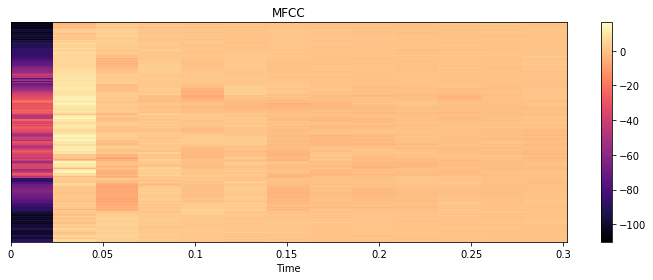

In [19]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time', cmap='magma')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

In [144]:
mfccs = librosa.feature.mfcc(y=signal, sr=sampling_rate, n_mfcc=numcep)

In [145]:
# librosa.feature.mfcc??

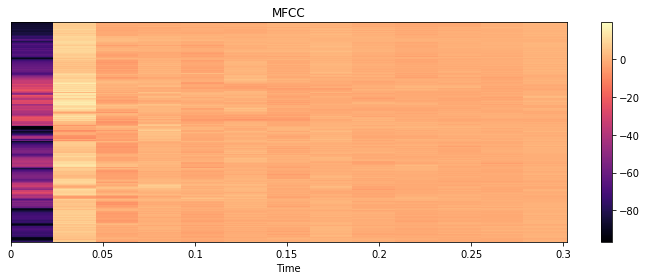

In [146]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time',cmap='magma')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()